In [52]:
import numpy as np
import pandas as pd
import pingouin as pg
import nibabel as nb
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
import os
from mvpa.loading import load_betas
from utils import Options
from nilearn.image import new_img_like
from nilearn.plotting import plot_roi, plot_stat_map

In [57]:
def mask_functional_map(func, anat):
    """
    Simple helper function to mask a
    functional map using
    an anatomical one.
    """
    
    funcdata = func.get_fdata()
    anatdata = anat.get_fdata()
    
    masked = new_img_like(func, funcdata * anatdata)
    
    return masked


def get_roi_avg(func, anat):
    
    funcdata = func.get_fdata()
    anatdata = anat.get_fdata()
    
    masked = funcdata[anatdata.astype(bool)]
    
    return np.nanmean(masked)

def get_avg_AnotB(func, anat_A, anat_B):
    
    funcdata = func.get_fdata()
    anatAdata = anat_A.get_fdata()
    anatBdata = anat_B.get_fdata()
    
    masked = funcdata[(anatAdata.astype(bool))&~(anatBdata.astype(bool))]
    
    return masked
    

In [3]:
# General settings
subjlist = [f'sub-{i:03d}' for i in range(1, 36) if i != 6]
roidir = '../../bids/derivatives/spm-preproc/derivatives/roi-masks/'
corrdir = '../../FIR_correlations/test_m29/ba-17-18_contr-objscrvsbas_top-500_nothresh/'
LOC_template = '{:s}_LO_contr-objvscr_top-500.nii'
corr_template = '{:s}_allruns_{:s}.nii'
MT_mask = nb.load('../../anat_roi_masks/glasser-v5.nii')
MST_mask = nb.load('../../anat_roi_masks/glasser-MST.nii')

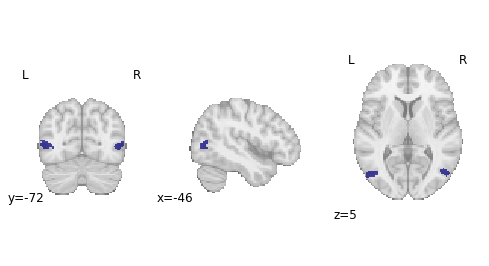

In [4]:
_ = plot_roi(MT_mask, draw_cross=False)

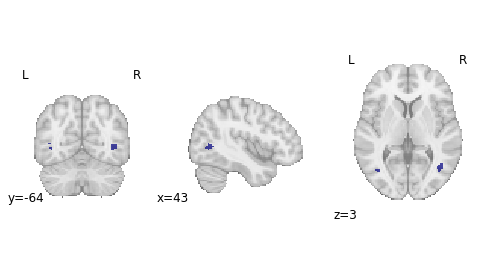

In [5]:
_ = plot_roi(MST_mask, draw_cross=False)

In [44]:
# Get LOC, MT and MST average 
# for each subject
df = []
for s in subjlist:
    thisLOCmask = nb.load(os.path.join(roidir, s, LOC_template.format(s)))
    for e in ['exp', 'unexp']:
        thisrow = {'subject': s, 'expected': e}
        thiscorrmap = nb.load(os.path.join(corrdir, corr_template.format(s, e)))
        LOCmean = get_roi_avg(thiscorrmap, thisLOCmask)
        MTmean = get_roi_avg(thiscorrmap, MT_mask)
        MSTmean = get_roi_avg(thiscorrmap, MST_mask)
        df.append(dict(thisrow, **{'roi': 'LOC', 'mean_corr': LOCmean}))
        df.append(dict(thisrow, **{'roi': 'MT', 'mean_corr': MTmean}))
        df.append(dict(thisrow, **{'roi': 'MST', 'mean_corr': MSTmean}))
        
df = pd.DataFrame(df)

In [45]:
df

,subject,expected,roi,mean_corr
0,sub-001,exp,LOC,0.875269
1,sub-001,exp,MT,0.604978
2,sub-001,exp,MST,0.839188
3,sub-001,unexp,LOC,-0.329892
4,sub-001,unexp,MT,-0.373439
...,...,...,...,...
199,sub-035,exp,MT,0.426968
200,sub-035,exp,MST,0.291745
201,sub-035,unexp,LOC,0.531790
202,sub-035,unexp,MT,0.519860


In [46]:
pg.ttest(df[(df['expected']=='exp')&(df['roi']=='LOC')]['mean_corr'],
         df[(df['expected']=='unexp')&(df['roi']=='LOC')]['mean_corr'],
         paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,2.516208,33,two-sided,0.016906,"[0.03, 0.28]",0.555882,2.772,0.882129


In [47]:
pg.ttest(df[(df['expected']=='exp')&(df['roi']=='MT')]['mean_corr'],
         df[(df['expected']=='unexp')&(df['roi']=='MT')]['mean_corr'],
         paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,3.781013,33,two-sided,0.000624,"[0.09, 0.31]",0.704724,48.708,0.978668


In [48]:
pg.ttest(df[(df['expected']=='exp')&(df['roi']=='MST')]['mean_corr'],
         df[(df['expected']=='unexp')&(df['roi']=='MST')]['mean_corr'],
         paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,2.298742,33,two-sided,0.027989,"[0.02, 0.28]",0.525309,1.825,0.844432


In [50]:
aov = pg.rm_anova(data=df, dv='mean_corr', subject='subject',
                  within=['roi', 'expected'])
pg.print_table(aov)


ANOVA SUMMARY

Source             SS    ddof1    ddof2     MS      F    p-unc    p-GG-corr    np2    eps
--------------  -----  -------  -------  -----  -----  -------  -----------  -----  -----
roi             0.022        2       66  0.011  0.712    0.494        0.486  0.021  0.935
expected        1.441        1       33  1.441  8.814    0.006        0.006  0.211  1.000
roi * expected  0.027        2       66  0.014  1.380    0.259        0.259  0.040  0.949



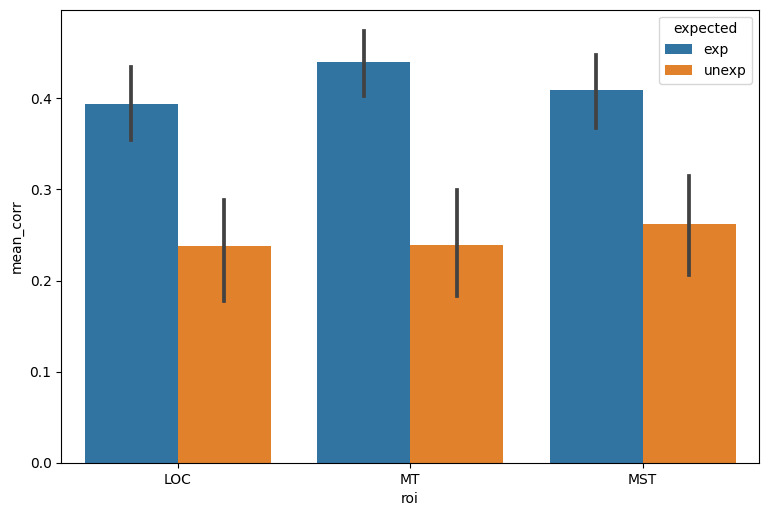

In [56]:
plt.figure(figsize=(9, 6), dpi=100)
sns.barplot(data=df, x='roi', y='mean_corr', hue='expected', ci=68)
plt.show()

In [29]:
LOCmean

0.5317902428139734

In [30]:
MTmean

0.5198596172553984

/home/predatt/giaald/.conda/envs/giacomo37/lib/python3.8/site-packages/nilearn/_utils/niimg.py:61: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(


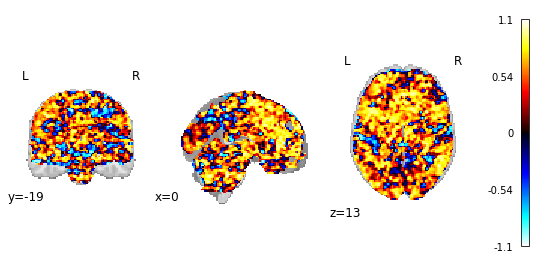

In [15]:
plot_stat_map(thiscorrmap, draw_cross=False)

In [12]:
LOCdata = mask_functional_map(thiscorrmap, thisLOCmask)

/home/predatt/giaald/.conda/envs/giacomo37/lib/python3.8/site-packages/nilearn/_utils/niimg.py:61: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(


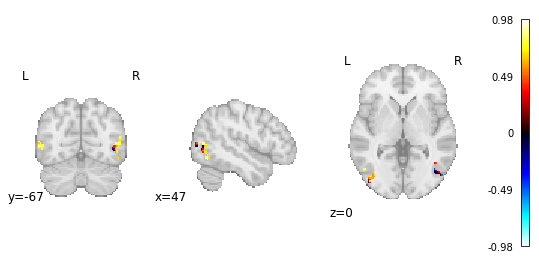

In [14]:
plot_stat_map(LOCdata, draw_cross=False)

In [16]:
corrdata = thiscorrmap.get_fdata()
maskdata = thisLOCmask.get_fdata()

In [20]:
masked=corrdata[maskdata.astype(bool)]

In [21]:
masked.shape

(500,)

In [23]:
np.nanmean(masked)

0.5317902428139734